In [30]:
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Num GPUs Available:  0


In [31]:
class AdaptiveBasisLayer(tf.keras.layers.Layer):
    def __init__(self, units=32, activation='tanh', **kwargs):
        super(AdaptiveBasisLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # Initialize weights and biases
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        # Compute the adaptive basis transformation
        return self.activation(tf.matmul(inputs, self.w) + self.b)

# Define the full PINN model with adaptive basis
class ABUPINN(tf.keras.Model):
    def __init__(self, layers=[(32, "tanh"), (32, "tanh"), (32, "tanh")]):
        super(ABUPINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dropout(rate=0.2)]
        for units, activation in layers:
            self.hidden_layers.append(AdaptiveBasisLayer(units=units, activation=activation))
        self.output_layer = tf.keras.layers.Dense(3)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        output = self.output_layer(x)
        return output

In [32]:
Lx = 10.0
Ly = 1.0
nu = 1

barrier_Lx = 0.3
barrier_Ly = 0.3

barrier_x = 3
barrier_y = Ly / 2 - barrier_Ly / 2

model = ABUPINN(layers=[(32, "tanh"), (32, "relu"), (32, "tanh")])


# Define the PDE residual
def compute_pde_residual(xy):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(xy)
        up = model(xy)
        u, v, p = up[:, 0], up[:, 1], up[:, 2]
        
        # First derivatives
        u_x = tape.gradient(u, xy)[:, 0]
        u_y = tape.gradient(u, xy)[:, 1]
        v_x = tape.gradient(v, xy)[:, 0]
        v_y = tape.gradient(v, xy)[:, 1]
        p_x = tape.gradient(p, xy)[:, 0]
        p_y = tape.gradient(p, xy)[:, 1]
        
        # Second derivatives
        u_xx = tape.gradient(u_x, xy)[:, 0]
        u_yy = tape.gradient(u_y, xy)[:, 1]
        v_xx = tape.gradient(v_x, xy)[:, 0]
        v_yy = tape.gradient(v_y, xy)[:, 1]
    
    # Continuity equation
    continuity = u_x + v_y
    
    # Momentum equations
    momentum_x = u*u_x + v*u_y + p_x - nu*(u_xx + u_yy)
    momentum_y = u*v_x + v*v_y + p_y - nu*(v_xx + v_yy)
    
    del tape
    
    return continuity, momentum_x, momentum_y

# Boundary conditions
def boundary_conditions():
    # careful, hard coded points count
    xys = generate_bc_data(num_points)
    
    bottom_bc, left_bc, top_bc, right_bc = xys

    bottom_predict = model(bottom_bc)
    left_predict = model(left_bc)
    top_predict = model(top_bc)
    right_predict = model(right_bc)
    
    # inflow
    u, v, p = left_predict[:, 0], left_predict[:, 1], left_predict[:, 2]
    bc_loss = tf.reduce_mean(tf.square(u - 1 * (Ly / 2 - tf.pow(0.5 - left_bc[:, 1] / Ly, 2))))

    # outflow
    u, v, p = right_predict[:, 0], right_predict[:, 1], right_predict[:, 2]
    bc_loss += tf.reduce_mean(tf.square(p))

    for wall in [bottom_predict, top_predict]:
        u, v, p = wall[:, 0], wall[:, 1], wall[:, 2]
        bc_loss += 1000 * tf.reduce_mean(tf.square(u) + tf.square(v))
    return bc_loss

# Boundary conditions
def boundary_conditions_barrier():
    # careful, hard coded points count
    xys = generate_bc_barrier_data(num_points)
    
    bottom_bc, left_bc, top_bc, right_bc, inside_bc = xys

    bottom_predict = model(bottom_bc)
    left_predict = model(left_bc)
    top_predict = model(top_bc)
    right_predict = model(right_bc)
    inside_predict = model(inside_bc)
    
    u, v, p = inside_predict[:, 0], inside_predict[:, 1], inside_predict[:, 2]
    bc_loss = tf.reduce_mean(tf.square(u) + tf.square(v) + tf.square(p))

    u, v, p = bottom_predict[:, 0], bottom_predict[:, 1], bottom_predict[:, 2]
    bc_loss += tf.reduce_mean(tf.square(u) + tf.square(v))
    u, v, p = left_predict[:, 0], left_predict[:, 1], left_predict[:, 2]
    bc_loss += tf.reduce_mean(tf.square(u) + tf.square(v))
    u, v, p = right_predict[:, 0], right_predict[:, 1], right_predict[:, 2]
    bc_loss += tf.reduce_mean(tf.square(u) + tf.square(v))
    u, v, p = top_predict[:, 0], top_predict[:, 1], top_predict[:, 2]
    bc_loss += tf.reduce_mean(tf.square(u) + tf.square(v))
    return bc_loss

# Training data
def generate_data(num_points):
    x = np.random.uniform(0, Lx, num_points)
    y = np.random.uniform(0, Ly, num_points)
    xy = np.stack([x, y], axis=-1)
    return tf.convert_to_tensor(xy, dtype=tf.float32)

def generate_bc_data(num_points):
    x = np.random.uniform(0, Lx, num_points)
    y = np.random.uniform(0, Ly, num_points)

    bottom = np.zeros(num_points)
    left = np.zeros(num_points)
    top = Ly * np.ones(num_points)
    right = Lx * np.ones(num_points)

    bottom_bc = np.stack([x, bottom], axis=-1)
    left_bc = np.stack([left, y], axis=-1)
    top_bc = np.stack([x, top], axis=-1)
    right_bc = np.stack([right, y], axis=-1)
    
    return (
        tf.convert_to_tensor(bottom_bc, dtype=tf.float32), 
        tf.convert_to_tensor(left_bc, dtype=tf.float32), 
        tf.convert_to_tensor(top_bc, dtype=tf.float32), 
        tf.convert_to_tensor(right_bc, dtype=tf.float32)
        )
    
def generate_bc_barrier_data(num_points):
    x = np.random.uniform(barrier_x, barrier_x + barrier_Lx, num_points)
    y = np.random.uniform(barrier_y, barrier_y + barrier_Ly, num_points)

    bottom = barrier_y * np.ones(num_points)
    left = barrier_x * np.ones(num_points)
    top = (barrier_y + barrier_Ly) * np.ones(num_points)
    right = (barrier_x + barrier_Lx) * np.ones(num_points)

    bottom_bc = np.stack([x, bottom], axis=-1)
    left_bc = np.stack([left, y], axis=-1)
    top_bc = np.stack([x, top], axis=-1)
    right_bc = np.stack([right, y], axis=-1)
    inside_bc = np.stack([x, y], axis=-1)
    
    return (
        tf.convert_to_tensor(bottom_bc, dtype=tf.float32), 
        tf.convert_to_tensor(left_bc, dtype=tf.float32), 
        tf.convert_to_tensor(top_bc, dtype=tf.float32), 
        tf.convert_to_tensor(right_bc, dtype=tf.float32), 
        tf.convert_to_tensor(inside_bc, dtype=tf.float32)
        )

# Loss function
def loss_function(xy):
    continuity, momentum_x, momentum_y = compute_pde_residual(xy)
    pde_loss = tf.reduce_mean(tf.square(continuity)) + \
               tf.reduce_mean(tf.square(momentum_x)) + \
               tf.reduce_mean(tf.square(momentum_y))
    bc_loss = boundary_conditions()
    bc_barrier_loss = boundary_conditions_barrier()
    return pde_loss, bc_loss, bc_barrier_loss

# Optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

# Training loop
num_epochs = 10000
num_points = 10000
try:
    for epoch in range(num_epochs):
        xy = generate_data(num_points)
        with tf.GradientTape() as tape:
            pde_loss, bc_loss, bc_barrier_loss = loss_function(xy)
            loss = pde_loss + bc_loss + bc_barrier_loss
        
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss.numpy()}\n'
                f'PDE Loss: {pde_loss}\n'
                f'BC Loss: {bc_loss}\n'
                f'BC Barrier Loss: {bc_barrier_loss}')
    print("Training completed.")
except KeyboardInterrupt as e:
    print(f"Training was interrupted on epoch {epoch}")
    print(f'Epoch {epoch}, Total Loss: {loss.numpy()}\n'
          f'PDE Loss: {pde_loss}\n'
          f'BC Loss: {bc_loss}\n'
          f'BC Barrier Loss: {bc_barrier_loss}')

Epoch 0, Total Loss: 1617.416259765625
PDE Loss: 0.04065496101975441
BC Loss: 1612.707275390625
BC Barrier Loss: 4.668333053588867
Epoch 100, Total Loss: 16.82960319519043
PDE Loss: 0.020815063267946243
BC Loss: 16.780960083007812
BC Barrier Loss: 0.027828041464090347
Epoch 200, Total Loss: 7.940576076507568
PDE Loss: 0.019539184868335724
BC Loss: 7.910454750061035
BC Barrier Loss: 0.010581936687231064
Epoch 300, Total Loss: 8.549403190612793
PDE Loss: 0.018521668389439583
BC Loss: 8.520325660705566
BC Barrier Loss: 0.010556058026850224
Epoch 400, Total Loss: 8.712388038635254
PDE Loss: 0.017237287014722824
BC Loss: 8.686746597290039
BC Barrier Loss: 0.00840359553694725
Epoch 500, Total Loss: 19.44147300720215
PDE Loss: 0.017097244039177895
BC Loss: 19.392366409301758
BC Barrier Loss: 0.03200923278927803
Epoch 600, Total Loss: 2.832746982574463
PDE Loss: 0.01736607402563095
BC Loss: 2.810739517211914
BC Barrier Loss: 0.004641185514628887
Epoch 700, Total Loss: 5.758307933807373
PDE Los

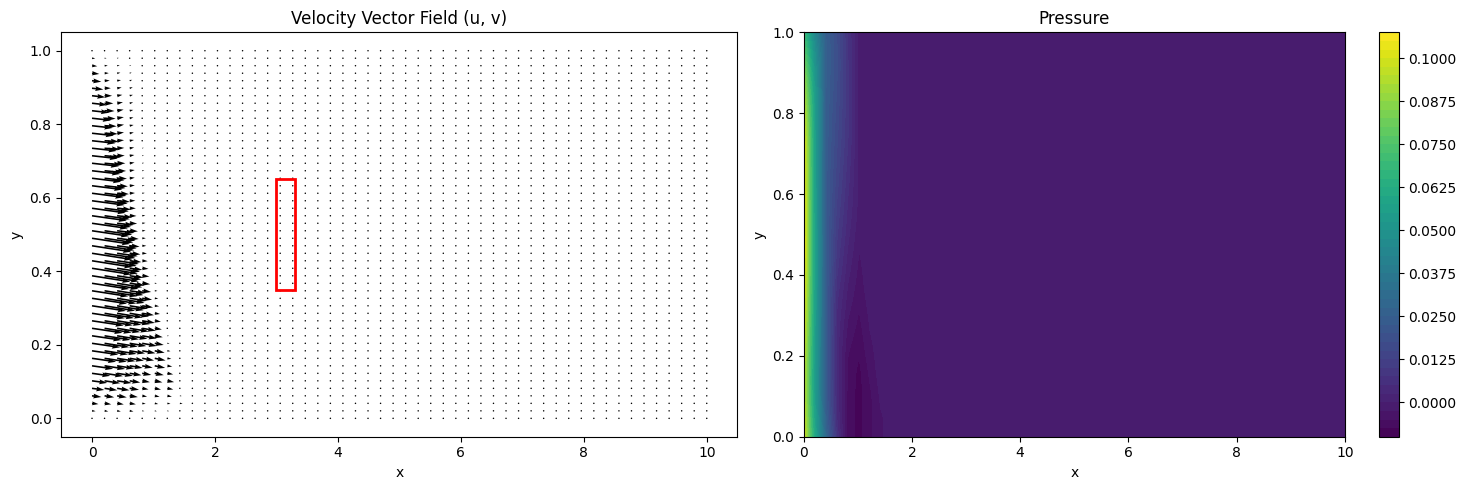

In [33]:
# Visualization
# Generate a grid over the domain
nx, ny = 50, 50
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)
XY = np.stack([X.flatten(), Y.flatten()], axis=-1)
XY_tensor = tf.convert_to_tensor(XY, dtype=tf.float32)

# Predict using the trained model
predictions = model(XY_tensor).numpy()
U = predictions[:, 0].reshape((ny, nx))
V = predictions[:, 1].reshape((ny, nx))
P = predictions[:, 2].reshape((ny, nx))

barrier = Rectangle((barrier_x, barrier_y), barrier_Lx, barrier_Ly, edgecolor='red', facecolor='none', linewidth=2)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Velocity vector field
axs[0].quiver(X, Y, U, V, scale=1., scale_units='xy')
axs[0].add_patch(barrier)
axs[0].set_title('Velocity Vector Field (u, v)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Pressure
c3 = axs[1].contourf(X, Y, P, levels=50, cmap='viridis')
# axs[1].add_patch(barrier)
axs[1].set_title('Pressure')
fig.colorbar(c3, ax=axs[1])
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.tight_layout()
plt.show()